In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

### Start up PBS cluster
 - may need to adjust project and/or walltime

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [4]:
client.cluster

### Some custom functions

In [5]:
def get_files(htape,yr0=1850,yr1=2014):
    d='/glade/campaign/asp/djk2120/PPEn11/transient/hist/'

    #find all files
    fs   = np.array(sorted(glob.glob(d+'*'+htape+'*')))
    yrs  = np.array([int(f.split(htape)[1][1:5]) for f in fs])
    keys = np.array([f.split('.clm2')[0][-7:] for f in fs])

    #bump back yr0, if needed
    uyrs=np.unique(yrs)
    dy=uyrs[1]-yrs[0]
    yr0=dy*int(yr0/dy)
    
    #find index to subset files
    ix   = (yrs>=yr0)&(yrs<=yr1)
    yrs  = yrs[ix]
    keys = keys[ix]

    #subset and reshape files
    ny=np.sum(keys=='LHC0000')
    nens = int(len(keys)/ny)
    files = fs[ix].reshape([nens,ny])

    #convert to list of lists
    files = [list(f) for f in files]
    
    return files,np.unique(keys)

In [6]:
def add_params(ds,df,keys):
    mems=df['member'].values
    ix1=0*mems==1
    for key in keys:
        ix1=(ix1)|(mems==key)

    nens=len(ds.ens)    
    ix2=0*np.arange(nens)==1
    for mem in mems:
        ix2=(ix2)|(ds.key==mem)


    params=[]    
    for p in df.keys():
        if p!='member':
            x=xr.DataArray(np.nan+np.zeros(nens),dims='ens')
            x[ix2]=df[p][ix1]
            ds[p]=x
            params.append(p)
    ds['params']=xr.DataArray(params,dims='param')

In [7]:
def get_ds(dvs,htape,yr0=1850,yr1=2014,dropdef=False):
    
    def preprocess(ds):
        return ds[dvs]
    
    #read in the data
    files,keys = get_files(htape,yr0,yr1)
    if dropdef:
        files = files[1:]
        keys  = keys[1:]
    
    ds = xr.open_mfdataset(files,combine='nested',concat_dim=['ens','time'],
                       parallel=True,preprocess=preprocess)
    
    #fix the time dimension, if needed
    yr0=str(ds['time.year'].values[0])
    if (htape=='h0')|(htape=='h1'):
        ds['time']=xr.cftime_range(yr0,periods=len(ds.time),freq='MS')
    
    #add some param info, etc.
    df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt')
    ds['key']=xr.DataArray(keys,dims=['ens'])
    add_params(ds,df,keys)
    
    #add landarea info
    la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
    la = xr.open_dataset(la_file).landarea  #km2
    ds['la'] = la
    
    #add some extra variables, e.g. lat/lon
    tmp = xr.open_dataset(files[0][0])
    for v in tmp.data_vars:
        if 'time' not in tmp[v].dims:
            ds[v]=tmp[v]   
    
    return ds
    

In [57]:
def gmean(da,la,cf=1):
    #global mean
    if 'gridcell' in da.coords:
        xg=cf/la.sum()*(la*da).sum(dim='gridcell').compute()
    else:
        xg=cf/la.sum()*(la*da).sum(dim=['lat','lon']).compute()
    return xg


In [9]:
whit = xr.open_dataset('./whit/whitkey.nc')
def bmean(da,la):
    g=whit.biome
    xb=1/la.groupby(g).sum()*(la*da).groupby(g).sum(dim='gridcell').compute()
    xb['biome_name']=xr.DataArray(whit.biome_name.values,dims='biome')
    return xb

In [10]:
def amean(da,cf=1):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf/365*(m*da).groupby('time.year').sum().compute()
    return xa

### Gridcell level output

In [240]:
#locate the output files
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h0'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1980
files = np.array(files)[yrs>=yr0]
tmp=xr.open_dataset(files[0])
la=tmp.area*tmp.landfrac

In [241]:
#read in the dataset
def preprocess(ds):
    dvs=['TLAI']
    return ds[dvs]
ds = xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                       decode_times=False,preprocess=preprocess)
ds['time']=xr.cftime_range(str(yr0),periods=len(ds.time),freq='MS',calendar='noleap')

In [86]:
#calculate fullgrid average LAI
lai_fg=gmean(amean(ds.TLAI),la)

In [87]:
#read in sparse grid information
thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sg = xr.open_dataset(thedir+thefile)
sgix = sg.rcent>0
la_file = '/glade/u/home/djk2120/clm5ppe/pyth/sparsegrid_landarea.nc'
lasg = xr.open_dataset(la_file).landarea  #km2

In [88]:
x=xr.DataArray(ds.TLAI.values[:,sgix],coords={'time':ds.time,'gridcell':range(400)})
lai_sg=gmean(amean(x),lasg)

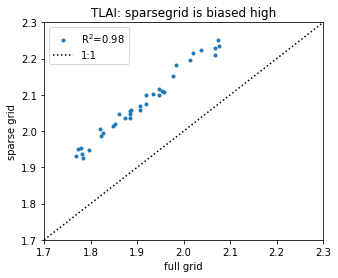

In [110]:
x=sm.add_constant(lai_fg)
lm=sm.OLS(lai_sg.values,x).fit()
r2=np.round(lm.rsquared,2)
m=np.round(lm.params[1],3)
b=np.round(lm.params[0],2)

plt.figure(figsize=[5,4])
plt.plot(lai_fg,lai_sg,'.',label=r'R$^2$='+str(r2))
plt.plot([1.7,2.3],[1.7,2.3],'k:',label='1:1')
plt.title('TLAI: sparsegrid is biased high')
plt.xlabel('full grid')
plt.ylabel('sparse grid')
plt.legend()
plt.xlim([1.7,2.3])
plt.ylim([1.7,2.3]);


### PFT-level output

In [391]:
#locate the output files
d='/glade/p/cgd/tss/people/oleson/clm51_lmbirchwkattgen01ctsm51d006_2deg_GSWP3V1_nocrop_PPE2_hist/lnd/hist/'
tape='h1'
files = sorted(glob.glob(d+'*.'+tape+'.*'))
yrs=np.array([int(f.split('.'+tape+'.')[1][:4]) for f in files])
yr0=1980
files = np.array(files)[yrs>=yr0]

In [392]:
#read in the dataset
def preprocess(ds):
    dvs=['TLAI']
    return ds[dvs]
ds1 = xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True,
                       decode_times=False,preprocess=preprocess)
ds1['time']=xr.cftime_range(str(yr0),periods=len(ds1.time),freq='MS',calendar='noleap')

In [393]:
#extra pft information
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pftname.values]
p=xr.open_dataset(files[0])
for v in ['pfts1d_'+vv for vv in ['wtgcell','lat','lon','itype_veg']]:
    ds1[v]=p[v]

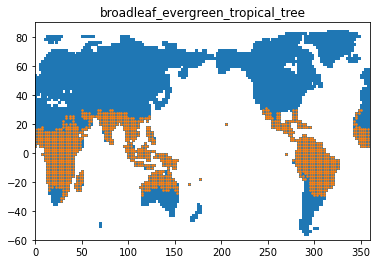

In [394]:
pft=4
w=ds1.pfts1d_wtgcell
a=ds1.pfts1d_lat
o=ds1.pfts1d_lon
ix=(ds1.pfts1d_itype_veg==pft)&(w>0)

plt.plot(o,a,'.',ms=3)
plt.plot(o[ix],a[ix],'.',ms=3)
plt.xlim([0,360])
plt.ylim([-60,90])
plt.title(pfts[pft]);

In [395]:
def regrid(ds,v,ds0,pft):
    w=ds.pfts1d_wtgcell
    a=ds.pfts1d_lat
    o=ds.pfts1d_lon
    
    #subset the data
    ix=(p.pfts1d_itype_veg==pft)&(w>0)
    dp=ds[v].sel(pft=ix).T.values  
    ap=a[ix].values
    op=o[ix].values
    wp=w[ix].values
    
    #create lat,lon matrices
    nlat,nlon,nt=len(ds0.lat),len(ds0.lon),len(ds.time)
    lats=np.tile(ds0.lat.values.reshape([-1,1]),[1,nlon])
    lons=np.tile(ds0.lon.values,[nlat,1])
    
    #populate output matrices
    dout=np.zeros([nt,nlat,nlon])+np.nan
    wout=np.zeros([nlat,nlon])
    for lat,lon,ww,dd in zip(ap,op,wp,dp):
        ixg=(lats==lat)&(lons==lon)
        wout[ixg]=ww
        dout[:,ixg]=dd.reshape([-1,1])
    
    #output dataset
    ds2=xr.Dataset()
    ds2[v]=xr.DataArray(dout,coords={'time':ds.time,
                                     'lat':ds0.lat,
                                     'lon':ds0.lon})
    ds2['wtgcell']=xr.DataArray(wout,dims=['lat','lon'])
    
    return ds2

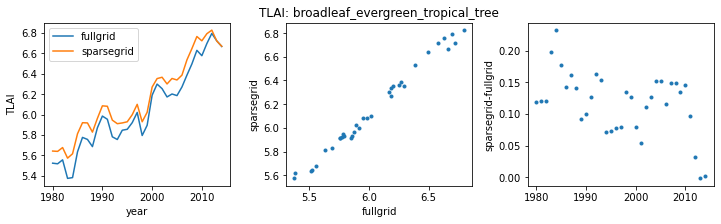

In [420]:
v='TLAI'
pft=4
ds2=regrid(ds1,v,ds,pft)

law=la*ds2.wtgcell
xfg=gmean(amean(ds2[v]),law)

x=xr.DataArray(ds2[v].values[:,sgix],coords={'time':ds1.time,'gridcell':range(400)})
w=ds2.wtgcell.values[sgix]
law=lasg*w
xsg=gmean(amean(x),law)

plt.figure(figsize=[12,3])
plt.subplot(131)
xfg.plot(label='fullgrid')
xsg.plot(label='sparsegrid')
plt.legend()
plt.ylabel('TLAI')

plt.subplot(132)
plt.plot(xfg,xsg,'.')
plt.ylabel('sparsegrid')
plt.xlabel('fullgrid')
plt.title('TLAI: '+pfts[pft]);

plt.subplot(133)
plt.plot(xfg.year,xsg-xfg,'.')
plt.ylabel('sparsegrid-fullgrid');

plt.subplots_adjust(wspace=0.3)

In [422]:
v='TLAI'
r2=np.zeros(17)
b=np.zeros(17)
for pft in 1+np.arange(16):
    
    ds2=regrid(ds1,v,ds,pft)
    
    law=la*ds2.wtgcell
    xfg=gmean(amean(ds2[v]),law)

    x=xr.DataArray(ds2[v].values[:,sgix],coords={'time':ds1.time,'gridcell':range(400)})
    w=ds2.wtgcell.values[sgix]
    law=lasg*w
    xsg=gmean(amean(x),law)
    
    r2[pft]=np.corrcoef(xfg,xsg)[0,1]**2
    b[pft]=xsg.mean()-xfg.mean()
    

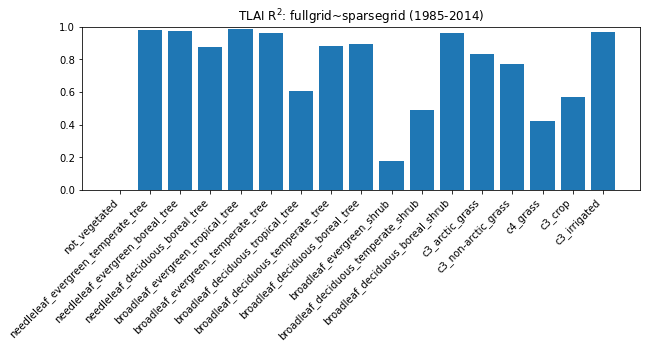

In [441]:
plt.figure(figsize=[10,3])
plt.bar(range(17),r2)
plt.xticks(range(17),pfts[:17],rotation=45,ha='right');
plt.ylim([0,1])
plt.title(r'TLAI R$^2$: fullgrid~sparsegrid (1985-2014)');

In [465]:
pd.DataFrame({r'R$^2$':np.round(r2,2),'bias':np.round(b,2)},index=pfts[:17])

,R$^2$,bias
not_vegetated,0.00,0.00
needleleaf_evergreen_temperate_tree,0.98,-0.14
needleleaf_evergreen_boreal_tree,0.97,-0.20
needleleaf_deciduous_boreal_tree,0.87,-0.10
broadleaf_evergreen_tropical_tree,0.99,0.12
broadleaf_evergreen_temperate_tree,0.96,-0.07
broadleaf_deciduous_tropical_tree,0.61,-0.21
broadleaf_deciduous_temperate_tree,0.88,-0.07
broadleaf_deciduous_boreal_tree,0.89,-0.19
broadleaf_evergreen_shrub,0.18,-0.06
